In [1]:
#!/usr/bin/env python
# coding: utf-8
#
########################################
#      cluster Gaussian surrogate      #
########################################
#Author: Hengrui Luo
#hrluo@lbl.gov
#Last update: 2021-Jan-13
#
########################################
#          System information          #
########################################
#Print the python version and the name/input arguments
#%pylab inline
import sys
print('Clean everything.')
sys.modules[__name__].__dict__.clear()
import sys
print("Python version: ", sys.version)
print("This is the name of the script: ", sys.argv[0])
print(sys.argv)

#Print the numpy version and set the random seed
import numpy as np
print('numpy version: ', np.__version__)
RND_SEED=111
np.random.seed(RND_SEED)

#Random string
#Get a random string stamp for this specific run, used for the filename of image export.
import random
import string
def get_random_string(length):
    return ''.join(random.choice(string.ascii_lowercase) for i in range(length))
rdstr=get_random_string(8)
print('random stamp for this run:',rdstr)

#Print the matplotlib version
import matplotlib
import matplotlib.pyplot as plt
print('matplotlib version: ', matplotlib.__version__)

#Print the GPy version
import GPy
print('GPy version: ', GPy.__version__)

#Print the GPy version
import sklearn
print('sklearn version: ', sklearn.__version__)
from sklearn.gaussian_process import GaussianProcessRegressor

#######################################
#         Model specification          #
########################################
#How many pilot and sequential samples do we allow to get?
#N_PILOT is the pilot samples we start with, usually a small number would do.
#N_SEQUENTIAL is the number of sequential (noisy) samples we should draw from the black-box function.
N_PILOT = 10     #int(sys.argv[1])
N_SEQUENTIAL =  10#int(sys.argv[2])
#Which method should we use for the Bayesian optimization scheme?
#'FREQUENTIST' method means that the (hyper-)parameters are estimated by using some frequestist optimization like lbfgs.
#'BAYESIAN' method means that the paramteres are estimated by putting a prior(Gamma)-posterior mechnism, the estimated value would be posterior mean.
METHOD  = 'FREQUENTIST'
#Following 3 parameters are only for HMC Bayesian sampling, you have to choose METHOD  = 'BAYESIAN' to use these parameters.
N_BURNIN = 500
N_MCMCSAMPLES = 500
N_INFERENCE = 300
#Exploration rate is the probability (between 0 and 1) of following the next step produced by acquisition function.
EXPLORATION_RATE = 1.0
#Do you want a cluster GP? If NO_CLUSTER = True, a simple GP will be used.
NO_CLUSTER = True

#Do you want to amplify the weight/role of response X when doing clustering?
X_AMPLIFY = 1#/4096
#Do you want to subtract an amount from the response X when doing clustering?
X_TRANSLATE = []
#Do you want to amplify the weight/role of response Y when doing clustering?
Y_AMPLIFY = 1#/1000
#Do you want to subtract an amount from the response Y when doing clustering?
Y_TRANSLATE = 0.
#What is the maximal number of cluster by your guess? This option will be used only if NO_CLUSTER=False.
N_COMPONENTS = 3
#When deciding cluster components, how many neighbors shall we look into and get their votes? This option will be used only if NO_CLUSTER=False.
N_NEIGHBORS = 1
#Amount of NUGGET in the GP surrogate that stabilize the GP model, especially in FREQUENTIST approach.
#NUGGET = 1e-4(Deprecated since ver 0.7, we can use a white kernel to estimate this)
#How many time shall we jitter the diagonal of the covariance matrix when we encounter numerical non-positive definiteness in Gaussian process surrogate fitting.
#This is a GPy parameter, default is 5 in GPy.
N_JITTER = 5
#Overriding GPy default jitter, dangerous jittering
GPy.util.linalg.jitchol.__defaults__ = (N_JITTER,)
print(GPy.util.linalg.jitchol.__defaults__)
#This is a GPy parameter, whether you want to normalize the response before/after fitting. Don't change unless necessary.
GPy_normalizer = True
#Whether we should sample repetitive locations in the sequential sampling procedure.
#If True, we would keep identical sequential samples no matter what. (Preferred if we believe a lot of noise)
#If False, we would re-sample when we run into identical sequential samples. (Default)
#In a acquisition maximization step, this is achieved by setting the acquisition function at repetitive samples to -Inf
#In a random search step, this is achieved by repeat the random selection until we got a new location.
REPEAT_SAMPLE = False
#ver 0.7 new, we can use sklearn GP regression implementation.
USE_SKLEARN = True
ALPHA_SKLEARN = 1e-5
#Value added to the diagonal of the kernel matrix during fitting. 
SKLEARN_normalizer = True

Clean everything.
Python version:  3.8.8 (default, Apr 13 2021, 19:58:26) 
[GCC 7.3.0]
This is the name of the script:  /home/hrluo/.local/lib/python3.8/site-packages/ipykernel_launcher.py
['/home/hrluo/.local/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/home/hrluo/.local/share/jupyter/runtime/kernel-9530242b-d35a-475d-84cf-05d84bf29eb0.json']
numpy version:  1.20.3
random stamp for this run: ptxlysjc
matplotlib version:  3.3.4
GPy version:  1.10.0
sklearn version:  0.24.2
(5,)


In [2]:
##################################################
#   Example 4: record dataset mapping, matmul    #
##################################################
EXAMPLE_NAME='matmul'
#This loads the dataset for building a black-box function
#The format of the dataset should be a csv file, the first column being the response (Y)
#The rest columns of the dataset is the d-dimensional inputs (X)
#
from numpy import genfromtxt
my_data = genfromtxt('Giulia_1000.csv', delimiter=',')
print(my_data.shape)
my_data = np.delete(my_data, (0), axis=0)
Y_obs = my_data[:,2].astype(float).reshape(-1,1)
X_obs = my_data[:,1].astype(float).reshape(-1,1)
#Dimension of the input domain
#d = X_obs.shape[1]
print(X_obs.shape)
print(Y_obs.shape)

########################################
#          Function wrapping           #
########################################
#This allows us to wrap a real-world dataset into the format of a black-box function useful 
#Given a point X, we find the closest point X' in the dataset (by some distance measure, currently L^2).
#The black-box function would return the observed response value Y' for X'. 
#This wrapping would makes the black-box function to be piece-wise constant. 
#
from scipy.spatial.distance import cdist
def f_truth(X):
    X = np.round(X) 
    to_obs = cdist(X,X_obs, metric='euclidean')
    closest_obs = np.argmin(to_obs)
    ret_X = X_obs[closest_obs,:]
    ret_Y = Y_obs[closest_obs,:]
    ret_X = int(X)
    #print(np.argwhere(ret_X==X_obs))
    #ret_Y = Y_obs[np.argwhere(ret_X==X_obs)[0,0],:]
    ret_Y = Y_obs[np.argmin(np.abs(ret_X-X_obs) ),:]
    print('Closest point in dataset is ',ret_X,' with observed value ',ret_Y[0])
    return ret_Y[0].astype(float)
point1 = np.ones((1,1))*128.5
print(f_truth(point1))
bounds = np.array([[1,1000]]).astype(float)
#print(bounds)

(1001, 3)
(1000, 1)
(1000, 1)
Closest point in dataset is  128  with observed value  2000.758
2000.758


In [3]:
N_GRID = 1024
x_p = [None]*bounds.shape[0]
for i in range(bounds.shape[0]):
    x_p[i] = np.linspace(start=bounds[i,0], stop=bounds[i,1], num=N_GRID)
    x0grid_ravel = np.vstack(np.meshgrid( *x_p )).reshape(bounds.shape[0],-1).T
    x0grid_ravel = np.arange(0,4096+1,8)
    x0grid_ravel = x0grid_ravel.astype(float).reshape(-1,1)
#You must supply a parameter called 'bounds'.
inp_dim=bounds.shape[0]

#Which kernel you want to use for your model? Such a kernel must be implemented as a GPy/sklearn kernel class.
if USE_SKLEARN==True:
    from sklearn.gaussian_process import *
    KERNEL_TEMPLATE = sklearn.gaussian_process.kernels.Matern(length_scale=np.ones(inp_dim,), length_scale_bounds=(1e-05, 100000.0), nu=3/2) + sklearn.gaussian_process.kernels.WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-03, 1000.0))
    #KERNEL_TEMPLATE = sklearn.gaussian_process.kernels.Matern(length_scale=np.ones(inp_dim,), length_scale_bounds=(1e-05, 100000.0), nu=1/2)
else:
    KERNEL_TEMPLATE = GPy.kern.Matern32(input_dim=inp_dim, variance=1., lengthscale=1.) + GPy.kern.White(input_dim=inp_dim)
    #KERNEL_TEMPLATE = GPy.kern.Exponential(input_dim=inp_dim, variance=1., lengthscale=1.)
#Do you want to penalize boundary sample points? If so, how?
def boundary_penalty(X,data_X=None):
    #return 0
    #return np.zeros((X.shape[0],1)) #if you don't want any penalty, use this line as the definition of your penalty
    #ret = []
    #for g in range(X.shape[0]):
    #    g_list = []
    #    for h in range(bounds.shape[1]):
    #        g_list.append( np.sum( (X[g,:]-bounds[:,h])**2 ) )
    #    ret.append(min(g_list))
    #res = X.astype(int)%8==0
    #return res*(100)\
    #if X<100:
    #    return -1e5
    if X.astype(int)%8==0:
        return 0
    else:
        return -1e3
    return -1e3
def censor_function(Y):
    #return Y #if you don't want any censor, use this line as the definition of your censor function.
    ret = Y
    #ret = Y.*(Y<20000 & Y>100)
    return ret#-np.minimum(0.1,10/np.asarray(ret))
#ver 0.6 new, 
#if random_domain returns TRUE, then such a choice by the random step is acceptable.
#if random_domain returns FALSE, then such a choice is out of our search input domain, and we would like to re-sample another random location.
def random_domain(X,data_X=None):
    #return True
    for i in range(data_X.shape[0]):
        if all(X.astype(int)== data_X[i,:].astype(int)) and ~REPEAT_SAMPLE: return False
        #This is only for matmul example searching only multiples of 8.
    return X.astype(int)%8==0 

In [4]:
from datetime import datetime
# datetime object containing current date and time
samplestartingtime = datetime.now()
########################################
#          Draw pilot samples          #
########################################
#This cell only provides a pilot sample.
#Prepare pilot samples (X,Y)
print('\n>>>>>>>>>>Sampling ',N_PILOT,' pilot samples...<<<<<<<<<<\n')
print('Example : ',EXAMPLE_NAME)
X_sample = np.zeros((N_PILOT,bounds.shape[0]))
Y_sample = np.zeros((N_PILOT,1))
for j in range(bounds.shape[0]):
    X_sample[:,j] = np.random.uniform(bounds[j,0],bounds[j,1],size=(N_PILOT,1)).ravel()
Y_sample = np.zeros((N_PILOT,1))
for k in range(N_PILOT):
    Y_sample[k,0] = f_truth(X_sample[k,:].reshape(1,-1))
    Y_sample[k,0] = censor_function(Y_sample[k,0])
#print('Pilot X',X_sample)
#print('Pilot Y',Y_sample)

from scipy.stats import norm
from scipy.optimize import minimize

from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture
from sklearn.neighbors import KNeighborsClassifier
#The cGP procedure consists of following steps
#Step 1. For observations, we can do a (unsupervised) (X,Y)-clustering and label them, different components are generated.
#Step 2. For predictive locations, we can do a (supervised) k-nearest neighbor classification, and predict at each location based on which component it belongs to. 
#Step 3. We compute the acquisition function and then proceed to the next sample, after adding the new sample we repeat Step 1 and 2.

#Prepare an up-to-date X_TRANSLATE, as the empirical mean of the X_sample
if len(X_TRANSLATE)>0:
    X_TRANSLATE = np.mean(X_sample,axis=0)
#Prepare an up-to-date Y_TRANSLATE, as the empirical mean of the Y_sample
if Y_TRANSLATE != 0:
    Y_TRANSLATE = np.mean(Y_sample)
#print(Y_sample - Y_TRANSLATE)
#Prepare initial clusters, with XY-joint.
XY_sample       = np.concatenate((X_AMPLIFY*(X_sample-X_TRANSLATE),Y_AMPLIFY*(Y_sample-Y_TRANSLATE).reshape(-1,1)),axis=1)
#dgm_XY = BayesianGaussianMixture(
#                    #weight_concentration_prior_type="dirichlet_distribution",
#                    weight_concentration_prior_type="dirichlet_process",
#                    n_components=N_COMPONENTS,#pick a big number, DGM will automatically adjust
#                    )
dgm_XY = KMeans(n_clusters=N_COMPONENTS, random_state=0)
XY_label = dgm_XY.fit_predict(XY_sample)
print('\n Initial labels for (X,Y)-joint clustering',XY_label)
#Make copies of X_sample for X-only fitting and XY-joint fitting.
X_sample_XY = np.copy(X_sample)
Y_sample_XY = np.copy(Y_sample)
#Prepare initial labels
clf_XY = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
clf_XY.fit(X_sample_XY, XY_label)
#This is an artifact, we need to have at least d samples to fit a d-dimensional GP model (for its mean and variance)
for c in np.unique(XY_label):
    if sum(XY_label==c)<=X_sample_XY.shape[1]:
        occ = np.bincount(XY_label)
        XY_label[np.where(XY_label==c)] = np.argmax(occ)

        
print(X_sample,Y_sample)
print(XY_sample)


>>>>>>>>>>Sampling  10  pilot samples...<<<<<<<<<<

Example :  matmul
Closest point in dataset is  613  with observed value  1138.652
Closest point in dataset is  170  with observed value  1473.382
Closest point in dataset is  437  with observed value  1413.69
Closest point in dataset is  769  with observed value  1067.934
Closest point in dataset is  296  with observed value  1561.486
Closest point in dataset is  150  with observed value  1595.116
Closest point in dataset is  23  with observed value  1192.724
Closest point in dataset is  421  with observed value  1446.274
Closest point in dataset is  239  with observed value  1546.418
Closest point in dataset is  338  with observed value  1566.698

 Initial labels for (X,Y)-joint clustering [1 2 2 1 0 0 1 2 0 0]
[[612.55800544]
 [169.90068459]
 [436.62296035]
 [769.49321005]
 [296.0299791 ]
 [150.01379418]
 [ 23.45584622]
 [420.80426777]
 [239.44345911]
 [338.3185357 ]] [[1138.652]
 [1473.382]
 [1413.69 ]
 [1067.934]
 [1561.486]
 [15

In [5]:
########################################
#        Draw sequential samples       #
########################################
from scipy import stats
from matplotlib import cm
mycm = cm.Spectral
VERBOSE = False
GETPLOT = False

#Prepare sequential samples (X,Y)
print('\n>>>>>>>>>>Sampling ',N_SEQUENTIAL,' sequential samples...<<<<<<<<<<\n')
X_sample = X_sample_XY
Y_sample = Y_sample_XY
cluster_label = XY_label

def get_KER():
    return KERNEL_TEMPLATE
#This recode function will turn the labels into increasing order,e.g. [1, 1, 3, 3, 0] ==> [0, 0, 1, 1, 2].
def recode(label):
    level = np.unique(np.array(label))
    ck = 0
    for j in level:
        label[label==j]=ck
        ck=ck+1
    return label
#Main loop that guides us in sampling sequential samples
comp_l = np.unique(np.array(cluster_label))

for it in range(N_SEQUENTIAL):
    print('\n>>>>>>>>>> ***** STEP ',it+1,'/',N_SEQUENTIAL,'***** <<<<<<<<<<')
    #Step 1. For observations, we can do a (unsupervised) (X,Y)-clustering and label them, different components are generated.
    #Create the (X,Y) joint sample to conduct (unsupervised clustering)
    if len(X_TRANSLATE)>0:
        X_TRANSLATE = np.mean(X_sample,axis=0)
    if Y_TRANSLATE != 0:
        Y_TRANSLATE = np.mean(Y_sample)
    #The cluster must be based on adjusted response value Y.
    XY_sample        = np.concatenate((X_AMPLIFY*(X_sample-X_TRANSLATE),Y_AMPLIFY*(Y_sample-Y_TRANSLATE).reshape(-1,1)),axis=1)
    if NO_CLUSTER:
        print('>>NO CLUSTER, a GP surrogate.')
        cluster_label    = np.zeros(XY_sample.shape[0])
    else:
        print('>>CLUSTERED, a cGP surrogate.',len(comp_l),' components in surrogate model.')
        cluster_label    = dgm_XY.fit_predict(XY_sample)#cluster_label
        if VERBOSE: print('dgm label', cluster_label)
        #Again, we need to ensure that every cluster has at least d (dimension of covariate) samples.
        for c in np.unique(cluster_label):
            if sum(cluster_label==c)<=X_sample.shape[1]:
                occ = np.bincount(cluster_label)
                cluster_label[np.where(cluster_label==c)] = np.argmax(occ)
        if VERBOSE: print('merged label',cluster_label)
    cluster_label = recode(cluster_label)
    if VERBOSE: print('All labels are recoded: ',cluster_label)
    #Create arrays to store the mean&variance at observed locations and predictive locations.
    n_component=len(np.unique(cluster_label))
    mean_fun = np.zeros((len(cluster_label),1))
    var_fun = np.copy(mean_fun)
    
    #Step 2. For predictive locations, we can do a (supervised) k-nearest neighbor classification, and predict at each location based on which component it belongs to. 
    clf_XY = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
    clf_XY.fit(X_sample,cluster_label)
        
    #Step 3. We either randomly search one location or compute the acquisition function and then proceed to the next sample, after adding the new sample we repeat Step 1 and 2.
    coin = np.random.uniform(0,1,1)
    if coin<EXPLORATION_RATE:
        print('>>>>Find next sample: acquisition proposal.')
        comp_l = np.unique(np.array(cluster_label))
        for c in comp_l:
            #Assign the corresponding X_sample and Y_sample values to the cluster coded by c. 
            c_idx = np.where(cluster_label == int(c))
            if VERBOSE: 
                print('>>>>Fitting component ',c,'/',len(comp_l)-1,' total components')
                print(c_idx)
            Xt = X_sample[c_idx].ravel().reshape(-1,X_sample.shape[1])
            Yt = Y_sample[c_idx].ravel().reshape(-1,1)
            #Fit the model with normalization
            if USE_SKLEARN==True:
                mt = GaussianProcessRegressor(kernel=get_KER(), random_state=0, normalize_y=SKLEARN_normalizer,alpha=ALPHA_SKLEARN,  
                                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=int(10*bounds.shape[0]))
            else:
                mt = GPy.models.GPRegression(Xt, Yt, kernel=get_KER(), normalizer=GPy_normalizer)
            ###
            if METHOD == 'FREQUENTIST':
                ##############################
                #Frequentist MLE GP surrogate#
                ##############################
                print('>>>>>>METHOD: frequentist MLE approach, component '+str(c)+'/'+str(len(comp_l)-1))
                print('>>>>>>SAMPLE: component sample size =',len(c_idx[0]) )
                if USE_SKLEARN==True:
                    mt.fit(Xt, Yt)
                    #No need to do more for sklearn GP
                    print('>>>>>>MODULE: sklearn is used, l-bfgs optimization.')
                    if VERBOSE: print(mt.kernel_, mt.log_marginal_likelihood(mt.kernel_.theta))
                else:
                    print('>>>>>>MODULE: GPy is used, l-bfgs optimization.')
                    mt.optimize(optimizer='bfgs', gtol = 1e-100, messages=VERBOSE, max_iters=int(10000*bounds.shape[0]))
                    mt.optimize_restarts(num_restarts=int(10*bounds.shape[0]),robust=True,verbose=VERBOSE)
            elif METHOD == 'BAYESIAN':
                if USE_SKLEARN: sys.exit('FUTURE: Currently we cannot fit with Bayesian method using sklearn, we have GPy only.')
                ##############################
                #Fully Bayesian GP surrogate #
                ##############################
                #Prior on the "hyper-parameters" for the GP surrogate model.
                print('>>>>>>METHOD: Fully Bayesian approach, component '+str(c)+'/'+str(len(comp_l)-1))
                print('>>>>>>SAMPLE: component sample size =',len(c_idx[0]) )
                mt.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
                mt.kern.variance.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
                #HMC sampling, fully Bayesian approach to estimate the kernel parameters.
                hmc = GPy.inference.mcmc.HMC(mt,stepsize=0.1)
                s = hmc.sample(num_samples=N_BURNIN) # Burnin
                s = hmc.sample(num_samples=N_MCMCSAMPLES)
                MCMC_samples = s[N_INFERENCE:] # cut out the burn-in period
                # Set the model parameters as the posterior mean
                mt.kern.variance[:]    = MCMC_samples[:,0].mean()
                mt.kern.lengthscale[:] = MCMC_samples[:,1].mean()
            #######################################
            # Optimization module(each component) #
            #######################################
            #mt2 predicts on observed locations.
            #No matter GRID_SEARCH true or not, we still need to predict on observed locations
            if USE_SKLEARN:
                mt2 = mt.predict(Xt,return_std=True, return_cov=False)
                mean_fun[c_idx,0] = mean_fun[c_idx,0] + mt2[0].reshape(1,-1)
                var_fun[c_idx,0]  = var_fun[c_idx,0]  + mt2[1].reshape(1,-1)
            else:
                mt2 = mt.predict(Xt)
                mean_fun[c_idx,0] = mean_fun[c_idx,0] + mt2[0].reshape(1,-1)#*np.std(Yt) + np.mean(Yt)
                var_fun[c_idx,0]  = var_fun[c_idx,0]  + mt2[1].reshape(1,-1)#*np.std(Yt)*np.std(Yt)
            #Define the expected improvement as objective function to optimize over.
            def my_obj(X):
                my_X = X.reshape(1, -1)
                my_X_label = clf_XY.predict(my_X)
                #If not in this component, set it to zero immediately.
                if my_X_label != int(c): return -0
                my_xi = 0.0 #tuning parameter, set it to zero for now.
                if USE_SKLEARN:
                    my_gp = mt.predict(my_X, return_std=True, return_cov=False)
                    my_mu = my_gp[0]
                    my_sigma = my_gp[1]
                else:
                    my_gp = mt.predict(my_X)
                    my_mu = my_gp[0]
                    my_sigma = my_gp[1]
                    my_sigma = np.sqrt(np.absolute(my_sigma)).reshape(-1, 1)
                my_mu = np.asarray(my_mu)
                my_sigma = np.asarray(my_sigma)
                with np.errstate(divide='warn'):
                    my_imp = my_mu - np.max(mt2[0].reshape(1,-1)) - my_xi
                    my_Z = np.divide(my_imp,my_sigma)
                    #norm = mvn(mean=np.zeros(X_sample[0,:].shape), cov=np.eye(X_sample.shape[1]))
                    my_ei = my_imp * norm.cdf(my_Z) + my_sigma * norm.pdf(my_Z)
                    my_ei[np.where(my_sigma <= 0.0)] = 0.0
                #Here we penalize the acquisition function value according to boundary_penalty function, by default this would be disabled. See document for details.
                my_ei = my_ei + boundary_penalty(my_X,X_sample)
                my_ei = float(my_ei.ravel())
                if VERBOSE: print('EI=',my_ei,'\n')
                return - my_ei/Xt.shape[0]
            #Optimize this my_obj using some optimization method.
            from scipy.optimize import minimize
            #from scipy.optimize import dual_annealing
            func = my_obj#lambda x:my_obj(x,mt,clf_XY) #Since the anneal finds minimum
            lw = bounds[:,0].tolist()
            up = bounds[:,1].tolist()
            #ret = dual_annealing(func, bounds=list(zip(lw, up)), seed=123)
            #dual annealing works for dim=1
            ret = minimize(fun=func, x0=np.random.uniform(bounds[:,0].T,bounds[:,1].T), bounds=list(zip(lw, up)), method='L-BFGS-B')
            print('>>>>Maximal acquisition function = ',-ret.fun,' attained at ',ret.x,' for component ',c)
            X_next = ret.x
    else:
        print('>>>>Find next sample: random search.')
        randomize_counter = 0
        X_rand = np.zeros((1,bounds.shape[0]))
        for j in range(bounds.shape[0]):
            X_rand[0,j] = np.random.uniform(bounds[j,0],bounds[j,1],1)
        X_next = X_rand
        #If we do not want repetitive samples, we sample until there are no points nearby. 
        while ~random_domain(X_next,X_sample):
            if VERBOSE: print('Random search: ',X_next,'hits a repetitive sample OR does not hit the random_domain constraint, resampling...')
            X_rand = np.zeros((1,bounds.shape[0]))
            for j in range(bounds.shape[0]):
                X_rand[0,j] = np.random.uniform(bounds[j,0],bounds[j,1],1)
            X_next = X_rand
            randomize_counter = randomize_counter + 1
        print('>>>>Random search stops after ',randomize_counter,' steps.')
    #Optional: Following are plotting features that tracks the optimization procedure
    X_next = X_next.reshape(1,-1)
    Y_next = f_truth(X_next)
    print('----------')
    print('>>Next sample input is chosen to be: ',X_next)
    print('>>Next sample response is chosen to be: ',Y_next.ravel())
    if GETPLOT:
        X_new = x0grid_ravel
        if bounds.shape[0]==1:
            fig, axs = plt.subplots(2,figsize=(6,6))
            fig.suptitle('Fitted surrogate model, sample size = '+str(X_sample.shape[0]))
            axs[0].plot(X_new,mean_new,color='b')
            axs[0].scatter(X_sample,Y_sample,color='b')
            axs[0].set_title('observed samples and mean')
            ci = np.sqrt(var_new)#/mean_new
            axs[0].fill_between(X_new.ravel(), (mean_new-ci).ravel(), (mean_new+ci).ravel(), color='b', alpha=.1)
            axs[1].plot(fine_grid,ei_grid,color='k')
            axs[1].scatter(X_next,ei_next,marker='v',color='r',s=100)
            axs[1].text(s='x='+str(X_next),x=X_next,y=np.max(ei_grid),color='r',fontsize=12)
            axs[1].set_title('acquisition/expected improvement function')
            plt.show()
        if bounds.shape[0]==2:
            fig, axs = plt.subplots(2,figsize=(6,12))
            fig.suptitle('Fitted surrogate model, sample size = '+str(X_sample.shape[0]))
            axs[0].scatter(X_new[:,0],X_new[:,1],c=mean_new.ravel(),cmap=mycm)
            axs[0].scatter(X_sample[:,0],X_sample[:,1],c=Y_sample.ravel(),cmap=mycm,marker='v',s=200,edgecolors='k')

            axs[0].set_title('observed samples and mean')
            ci = np.sqrt(var_new)#/mean_new
            axs[1].scatter(fine_grid[:,0],fine_grid[:,1],c=ei_grid.ravel(),cmap=mycm)
            axs[1].scatter(X_next[0,0],X_next[0,1],marker='v',color=None,s=200,edgecolors='k')
            axs[1].text(s='x='+str(X_next),x=X_next[0,0],y=X_next[0,1],color='k',fontsize=12)
            axs[1].set_title('acquisition/expected improvement function')
            plt.show()
        #plt.savefig('cGP'+rdstr+'_step'+str(it)+'_'+str(n)+'_'+str(m)+'_'+str(l)+'.png')
    #Update X and Y from this step.
    X_sample = np.vstack((X_sample,X_next))
    Y_sample = np.vstack((Y_sample,censor_function(Y_next) ))




>>>>>>>>>>Sampling  10  sequential samples...<<<<<<<<<<


>>>>>>>>>> ***** STEP  1 / 10 ***** <<<<<<<<<<
>>NO CLUSTER, a GP surrogate.
>>>>Find next sample: acquisition proposal.
>>>>>>METHOD: frequentist MLE approach, component 0.0/0
>>>>>>SAMPLE: component sample size = 10
>>>>>>MODULE: sklearn is used, l-bfgs optimization.
>>>>Maximal acquisition function =  -97.19646216165631  attained at  [283.48205456]  for component  0.0
Closest point in dataset is  283  with observed value  1546.39
----------
>>Next sample input is chosen to be:  [[283.48205456]]
>>Next sample response is chosen to be:  [1546.39]

>>>>>>>>>> ***** STEP  2 / 10 ***** <<<<<<<<<<
>>NO CLUSTER, a GP surrogate.
>>>>Find next sample: acquisition proposal.
>>>>>>METHOD: frequentist MLE approach, component 0.0/0
>>>>>>SAMPLE: component sample size = 11
>>>>>>MODULE: sklearn is used, l-bfgs optimization.
>>>>Maximal acquisition function =  -90.90909086134701  attained at  [669.93063801]  for component  0.0
Closest poin

 /home/hrluo/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.


>>>>>>MODULE: sklearn is used, l-bfgs optimization.
>>>>Maximal acquisition function =  0.00012125280896686334  attained at  [840.72907908]  for component  0.0
Closest point in dataset is  841  with observed value  1036.2
----------
>>Next sample input is chosen to be:  [[840.72907908]]
>>Next sample response is chosen to be:  [1036.2]

>>>>>>>>>> ***** STEP  7 / 10 ***** <<<<<<<<<<
>>NO CLUSTER, a GP surrogate.
>>>>Find next sample: acquisition proposal.
>>>>>>METHOD: frequentist MLE approach, component 0.0/0
>>>>>>SAMPLE: component sample size = 16
>>>>>>MODULE: sklearn is used, l-bfgs optimization.
>>>>Maximal acquisition function =  0.01860193121875317  attained at  [1000.]  for component  0.0
Closest point in dataset is  1000  with observed value  994.916
----------
>>Next sample input is chosen to be:  [[1000.]]
>>Next sample response is chosen to be:  [994.916]

>>>>>>>>>> ***** STEP  8 / 10 ***** <<<<<<<<<<
>>NO CLUSTER, a GP surrogate.
>>>>Find next sample: acquisition proposa

In [6]:
sampleendingtime = datetime.now()
# dd/mm/YY H:M:S
samplestartingtime  = samplestartingtime.strftime("%Y/%m/%d %H:%M:%S")
sampleendingtime  = sampleendingtime.strftime("%Y/%m/%d %H:%M:%S")
print("Sample start date and time =", samplestartingtime)
print("Sample end date and time =", sampleendingtime)
#print(X_sample)
#print(Y_sample)
#print(np.hstack((Y_sample,X_sample)).shape)
if NO_CLUSTER==True:
    FILE_NAME = EXAMPLE_NAME+'_local_GP('+rdstr+')'
else:
    FILE_NAME = EXAMPLE_NAME+'_local_cGP_k='+str(N_COMPONENTS)+'('+rdstr+')'
np.savetxt(FILE_NAME+'.txt', np.hstack((Y_sample,X_sample)), delimiter =', ')  

sample_max_x = X_sample[np.argmax(Y_sample),:] 
sample_max_f = np.round( Y_sample[np.argmax(Y_sample),:],3)
sample_min_x = X_sample[np.argmin(Y_sample),:] 
sample_min_f = np.round( Y_sample[np.argmin(Y_sample),:],3)

Sample start date and time = 2021/09/06 12:45:01
Sample end date and time = 2021/09/06 12:45:03


In [7]:
if True:
    original_stdout = sys.stdout # Save a reference to the original standard output
    with open(FILE_NAME+'.log', 'w') as f:
        sys.stdout = f # Change the standard output to the file we created.
        #print('This message will be written to a file.')
        print("Example: ",EXAMPLE_NAME,file=f)
        print("Sample start date and time = ", samplestartingtime)
        print("Sample end date and time = ", sampleendingtime)
        print("Python version: ", sys.version)
        #print("Filename of the script: ", sys.argv[0])
        print("Commandline arguments: ",sys.argv)
        print("Random seed: ",RND_SEED)
        print('Random stamp: ',rdstr)
        print('GPy version: ', GPy.__version__)
        print('sklearn version: ', sklearn.__version__)
        print('Number of pilot samples: ',N_PILOT)
        print('Number of sequential samples: ',N_SEQUENTIAL)
        print('Surrogate fitting method: ',METHOD)
        if METHOD=="BAYESIAN":
            print('MCMC>Burn-in steps: ',N_BURNIN)
            print('MCMC>Sampling steps: ',N_MCMCSAMPLES)
            print('MCMC>Inference sample length: ',N_INFERENCE)
        print('Surrogate> Are we using sklearn for GPR?: ',USE_SKLEARN)
        print('Surrogate> kernel type: ',get_KER())
        if USE_SKLEARN:
            print('Surrogate>sklearn>jittering: ',ALPHA_SKLEARN)
            print('Surrogate>sklearn>normalizer; ',SKLEARN_normalizer)
        else:
            #print('Surrogate>GPy>Nugget noise variance',NUGGET)
            print('Surrogate>GPy>jittering: ',N_JITTER)
            print('Surrogate>GPy>normalizer; ',GPy_normalizer)
        print('Surrogate> Fit a simple GP?(no cluster): ',NO_CLUSTER)
        print('Cluster> Response amplifier when clustering: ',Y_AMPLIFY)
        print('Cluster> Maximal number of components/clusters: ',N_COMPONENTS)
        print('Classify> k in k-nearest neighbor classifier',N_NEIGHBORS)
        print('Exploration rate: ',EXPLORATION_RATE)
        #print('Exploration> Do we perform grid-search in acquisition maximization?',GRID_SEARCH)
        print('Exploration> Do we allow repeat samples in random searching?',REPEAT_SAMPLE)
        print('domain bounds: ',bounds)
        #print('blur amount: ',blur_amount)
        print('sample minimum, f_min=',sample_min_f,' at ',sample_min_x)
        print('sample maximum, f_max=',sample_max_f,' at ',sample_max_x)
        print('>>Cluster X_AMPLIFY=',X_AMPLIFY)
        print('>>Cluster X_TRANSLATE=',X_TRANSLATE)
        print('>>Cluster Y_AMPLIFY=',Y_AMPLIFY)
        print('>>Cluster Y_TRANSLATE=',Y_TRANSLATE)
    sys.stdout = original_stdout # Reset the standard output to its original value

#%debug
import os
print('Logs of run with stamp: ',rdstr,', is saved at',os.getcwd())

Logs of run with stamp:  ptxlysjc , is saved at /media/hrluo/ALL/cGP/Sec3_1


In [8]:
cluster_label    = dgm_XY.fit_predict(XY_sample)#cluster_label
prediction_label = clf_XY.predict(x0grid_ravel)#XY_predlabel
print('dgm label', cluster_label)
#Again, we need to ensure that every cluster has at least d (dimension of covariate) samples.
for c in np.unique(cluster_label):
    if sum(cluster_label==c)<=X_sample.shape[1]:
        occ = np.bincount(cluster_label)
        cluster_label[np.where(cluster_label==c)] = np.argmax(occ)
print('merged label',cluster_label)

dgm label [1 0 0 1 0 0 1 0 0 0 0 1 0 2 1 1 1 1 0]
merged label [1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

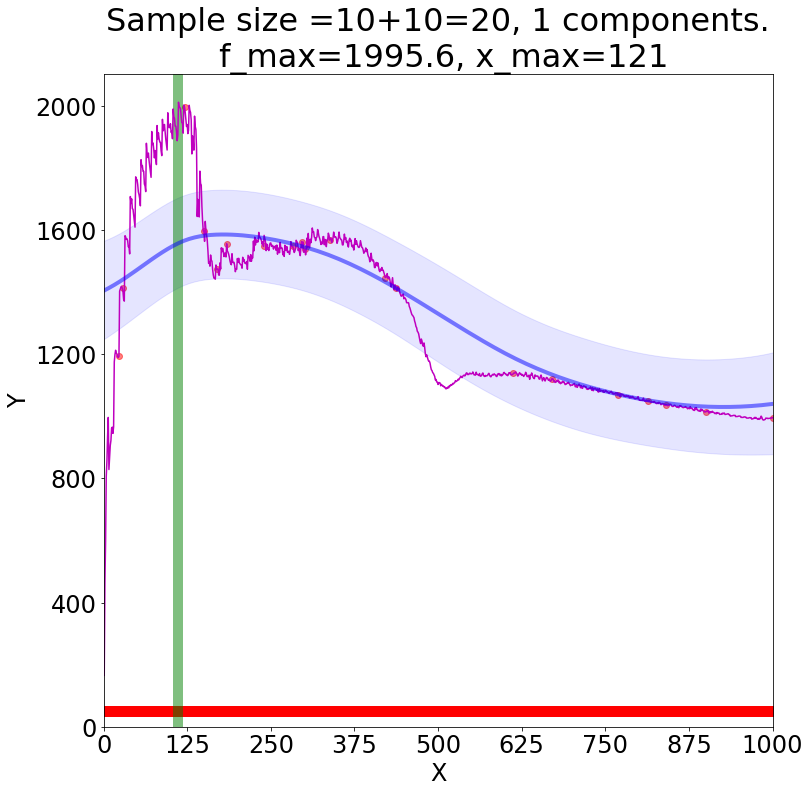

sample minimum, f_min= [994.916]  at  [1000.]
sample maximum, f_max= [1995.6]  at  [120.99999638]
>>Cluster X_AMPLIFY= 1
>>Cluster X_TRANSLATE= []
>>Cluster Y_AMPLIFY= 1
>>Cluster Y_TRANSLATE= 0.0


In [11]:
########################################
#      Plot the final model(1/2D)      #
########################################
mycm = cm.coolwarm
X_new = x0grid_ravel
fine_grid = x0grid_ravel
prediction_label = clf_XY.predict(x0grid_ravel)
new_label = clf_XY.predict(X_new)
col=['r','k','y','b','g'] #Generate a color scale, here usually there would not be more than 5 components.
mean_new = np.zeros((len(prediction_label),1))
var_new = np.copy(mean_new)
fig = plt.figure(figsize=(12,12))
#from IPython.display import display
if len(X_TRANSLATE)>0:
    X_TRANSLATE = np.mean(X_sample,axis=0)
if Y_TRANSLATE != 0:
    Y_TRANSLATE      = np.mean(Y_sample)
XY_sample        = np.concatenate((X_AMPLIFY*(X_sample-X_TRANSLATE),Y_AMPLIFY*(Y_sample-Y_TRANSLATE).reshape(-1,1)),axis=1)
#XY_sample        = np.concatenate((X_sample,Y_AMPLIFY*Y_sample.reshape(-1,1)),axis=1)
if NO_CLUSTER: 
    cluster_label    = np.zeros(XY_sample.shape[0])
    prediction_label = x0grid_ravel*0.
else:
    cluster_label    = dgm_XY.fit_predict(XY_sample)#cluster_label
    prediction_label = clf_XY.predict(x0grid_ravel)#XY_predlabel
    if VERBOSE: print('dgm label', cluster_label)
    #Again, we need to ensure that every cluster has at least d (dimension of covariate) samples.
    for c in np.unique(cluster_label):
        if sum(cluster_label==c)<=X_sample.shape[1]:
            occ = np.bincount(cluster_label)
            cluster_label[np.where(cluster_label==c)] = np.argmax(occ)
    if VERBOSE: print('merged label',cluster_label)
cluster_label = recode(cluster_label)
clf_XY = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
clf_XY.fit(X_sample,cluster_label)
#if GRID_SEARCH==True:
new_label = clf_XY.predict(X_new)
for c in np.unique(cluster_label):
            if sum(cluster_label==c)<=X_sample.shape[1]:
                occ = np.bincount(cluster_label)
                cluster_label[np.where(cluster_label==c)] = np.argmax(occ)
cluster_label = recode(cluster_label)
print(cluster_label)
new_label = recode(new_label)
print(new_label)
for c in np.unique(np.array(cluster_label)):
        print('Fitting component ',c)
        c = int(c)
        #Assign the corresponding X_sample and Y_sample values to the cluster coded by c. 
        c_idx = np.where(cluster_label == int(c))
        if len(c_idx) <1: continue
        print(c_idx)
        Xt = X_sample[c_idx].ravel().reshape(-1,X_sample.shape[1])
        Yt = Y_sample[c_idx].ravel().reshape(-1,1)
        #print(Xt.shape,Yt.shape)
        #print(Xt,Yt)
        #Normalization
        #Fit the model
        if 'mt' in locals():
            del(mt)
            # mt exists.
        if USE_SKLEARN:
            mt = GaussianProcessRegressor(kernel=get_KER(), random_state=0, normalize_y=SKLEARN_normalizer, alpha=ALPHA_SKLEARN,  
                                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=int(10*bounds.shape[0]))
            mt.fit(Xt, Yt)
            print('Summary of component '+str(c)+' GP surrogate model.')
            print(mt.kernel_, mt.log_marginal_likelihood(mt.kernel_.theta))

        else:
            mt = GPy.models.GPRegression(Xt, Yt, kernel=get_KER(), normalizer=GPy_normalizer)
            mt.optimize(optimizer='bfgs', gtol = 10e-32, messages=False, max_iters=int(10000*bounds.shape[0]))
            mt.optimize_restarts(num_restarts=int(100*bounds.shape[0]),robust=True,verbose=False)
            #mt.plot()
            #plt.show()
            print('Summary of component '+str(c)+' GP surrogate model.')
            display(mt)
        c_idx_new = np.where(new_label == int(c))
        c_idx_new = c_idx_new[0]
        if len(c_idx_new) <1: continue
        print(c_idx_new)
        #print(mean_new.shape)
        if USE_SKLEARN:
            mt1 = mt.predict(X_new[c_idx_new],return_std=True, return_cov=False)
            mt2 = mt.predict(fine_grid,return_std=True, return_cov=False)
            mu_new = mt1[0]
            sigma2_new = np.power(mt1[1],2)
        else:
            mt1 = mt.predict(X_new[c_idx_new])
            mt2 = mt.predict(fine_grid)
            mu_new = mt1[0]
            sigma2_new = mt1[1]
            
        mean_new[c_idx_new,0] = mean_new[c_idx_new,0] + mu_new.reshape(1,-1)
        var_new[c_idx_new,0]  = var_new[c_idx_new,0]  + sigma2_new.reshape(1,-1)
        
        if bounds.shape[0] == 1:
            plt.scatter(X_new[c_idx_new],np.ones(X_new[c_idx_new].shape)*0+50,c=col[c],alpha=1,marker='s',s=100)
            #plt.plot(fine_grid, mt2[0],color=col[c],linestyle='--',label='component '+str(c)+' mean')
            plt.scatter(X_sample[c_idx],   Y_sample[c_idx],label='sequential samples',c=col[c],alpha=0.5)
plt.plot(X_obs,Y_obs,c='m')
plt.vlines(x=112, ymin=0, ymax=35000,color='g',linewidth=10,alpha=0.5)

if bounds.shape[0] == 1:
    print('1d plot')
    plt.plot(X_new,mean_new,color='b',linewidth=4,alpha=0.5,label='overall mean')
    plt.fill_between(X_new.ravel(), (mean_new-np.sqrt(var_new)).ravel(), (mean_new+np.sqrt(var_new)).ravel(), color='b', alpha=.1, label='overall std. deviation')
   
    #plt.vlines(x=sample_max_x, ymin=0, ymax=sample_max_f,color='b',linestyle='-.')
    #plt.text(s='sample max:'+str(sample_max_f[0])+'\n @'+str(sample_max_x),x=sample_max_x,y=100,c='k',fontsize=12,rotation=45)
    #plt.text(s=str(sample_max_x[0]),x=sample_max_x,y=20,c='b',fontsize=12)

    ##plt.vlines(x=sample_min_x, ymin=0, ymax=sample_min_f,color='b',linestyle='-.')
    #plt.text(s='sample min:'+str(sample_min_f[0])+'\n @'+str(sample_min_x),x=sample_min_x,y=100,c='k',fontsize=12,rotation=45)
    #plt.text(s=str(sample_min_x[0]),x=sample_min_x,y=10,c='b',fontsize=12)

    plt.title('Sample size ='+str(N_PILOT)+'+'+str(N_SEQUENTIAL)+'='+str(X_sample.shape[0])+', '+str(len(np.unique(np.array(cluster_label))))+' components.'+\
              '\n f_max='+str(sample_max_f[0])+', x_max='+str(np.round(sample_max_x[0]).astype(int)),fontsize=32)
    plt.ylabel('Y', fontsize=24)
    plt.xlabel('X', fontsize=24)
    plt.xlim((0,1001))
    plt.ylim((0,2000))
    plt.xticks(np.linspace(0, 1000, 9), fontsize=24)
    plt.yticks(np.linspace(0, 2000, 6), fontsize=24)
    #plt.legend(fontsize=18,loc='lower center')
    
if bounds.shape[0] == 2:
    print('2d plot')
    plt.scatter(X_new[:,0],      X_new[:,1],      c=mean_new.ravel(),cmap=mycm,alpha=1.0,label='overall mean',marker='s',s=200)
    plt.scatter(X_sample[:,0],   X_sample[:,1],   c=Y_sample.ravel(),cmap=mycm,alpha=1.0,label='sequential samples',edgecolors='k')
    plt.scatter(X_sample_XY[:,0],X_sample_XY[:,1],c=Y_sample_XY.ravel(),cmap=mycm,alpha=1.0,label='pilot samples',marker='v',s=150,edgecolors='k')
    #plt.scatter(x=x_min[0], y=x_min[1], color='k')
    #plt.text(s='model min:'+str(f_min[0])+'\n @'+str(x_min),x=x_min[0],y=x_min[1],c='k',fontsize=12,rotation=45)

    #plt.scatter(x=x_max[0], y=x_max[1], color='k')
    #plt.text(s='model max:'+str(f_max[0])+'\n @'+str(x_max),x=x_max[0],y=x_max[1],c='k',fontsize=12,rotation=45)

    #plt.scatter(x=sample_max_x[0], y=sample_max_x[1], color='k')
    #plt.text(s='sample max:'+str(sample_max_f[0])+'\n @'+str(sample_max_x),x=sample_max_x[0],y=sample_max_x[1],c='k',fontsize=12,rotation=45)
    #plt.text(s=str(sample_max_x[0]),x=sample_max_x,y=20,c='b',fontsize=12)

    #plt.scatter(x=sample_min_x[0], y=sample_min_x[1], color='k')
    #plt.text(s='sample min:'+str(sample_min_f[0])+'\n @'+str(sample_min_x),x=sample_min_x[0],y=sample_min_x[1],c='k',fontsize=12,rotation=45)
    #plt.text(s=str(sample_min_x[0]),x=sample_min_x,y=10,c='b',fontsize=12)

    #plt.title('Sample size ='+str(X_sample.shape[0]),fontsize=24)
    plt.xlabel('X1', fontsize=24)
    plt.ylabel('X2', fontsize=24)
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.xticks(np.linspace(-1, 1, 6), fontsize=24)
    plt.yticks(np.linspace(-1, 1, 6), fontsize=24)
    
    #plt.legend()

plt.ylim((0,2100))
#plt.yticks(ticks=[21000,23000,25000,27000,29000,31000])
plt.show()
fig.savefig(FILE_NAME+'.png', dpi=fig.dpi)
print('sample minimum, f_min=',sample_min_f,' at ',sample_min_x)
print('sample maximum, f_max=',sample_max_f,' at ',sample_max_x)
print('>>Cluster X_AMPLIFY=',X_AMPLIFY)
print('>>Cluster X_TRANSLATE=',X_TRANSLATE)
print('>>Cluster Y_AMPLIFY=',Y_AMPLIFY)
print('>>Cluster Y_TRANSLATE=',Y_TRANSLATE)

In [10]:
print(X_sample)

[[ 612.55800544]
 [ 169.90068459]
 [ 436.62296035]
 [ 769.49321005]
 [ 296.0299791 ]
 [ 150.01379418]
 [  23.45584622]
 [ 420.80426777]
 [ 239.44345911]
 [ 338.3185357 ]
 [ 283.48205456]
 [ 669.93063801]
 [ 301.37490627]
 [ 120.99999638]
 [ 900.87377588]
 [ 840.72907908]
 [1000.        ]
 [ 813.95315012]
 [  28.42051185]
 [ 184.000369  ]]
